In [ ]:
!pip install torchinfo

In [1]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import polars as pl
import pandas as pd
import sklearn
import networkx as nx
import ipywidgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from torch import Tensor
from einops import rearrange
from typing import Tuple, Callable
from torch.autograd import Function

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

In [13]:
class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super(CausalConv1D, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]

class BlockDiagonal(nn.Module):
    def __init__(self, in_features, out_features, num_blocks):
        super(BlockDiagonal, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_blocks = num_blocks

        assert out_features % num_blocks == 0

        block_out_features = out_features // num_blocks

        self.blocks = nn.ModuleList([
            nn.Linear(in_features, block_out_features)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        x = [block(x) for block in self.blocks]
        x = torch.cat(x, dim=-1)
        return x

class sLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=4/3):
        super(sLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.causal_conv = CausalConv1D(1, 1, 4)

        self.Wz = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wi = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wf = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wo = BlockDiagonal(input_size, self.hidden_size, num_heads)

        self.Rz = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ri = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Rf = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ro = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

        self.up_proj_left = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.up_proj_right = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.down_proj = nn.Linear(int(self.hidden_size * proj_factor), input_size)

    def forward(self, x, prev_state):
        assert x.size(-1) == self.input_size
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)

        x_norm = self.layer_norm(x)
        x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))
        z = torch.tanh(self.Wz(x_norm) + self.Rz(h_prev))
        o = torch.sigmoid(self.Wo(x_norm) + self.Ro(h_prev))
        i_tilde = self.Wi(x_conv) + self.Ri(h_prev)
        f_tilde = self.Wf(x_conv) + self.Rf(h_prev)

        # TODO !!!!
        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t) # Всегда <= 1.0
        f = torch.exp(f_tilde + m_prev - m_t) # Всегда <= 1.0

        c_t = f * c_prev + i * z
        n_t = f * n_prev + i
        h_t = o * c_t / n_t

        output = h_t
        output_norm = self.group_norm(output)
        output_left = self.up_proj_left(output_norm)
        output_right = self.up_proj_right(output_norm)
        output_gated = F.gelu(output_right)
        output = output_left * output_gated
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)

class sLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=4/3):
        super(sLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([sLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

class mLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=2):
        super(mLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.up_proj_left = nn.Linear(input_size, int(input_size * proj_factor))
        self.up_proj_right = nn.Linear(input_size, self.hidden_size)
        self.down_proj = nn.Linear(self.hidden_size, input_size)

        self.causal_conv = CausalConv1D(1, 1, 4)
        self.skip_connection = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.Wq = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wk = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wv = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wi = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wf = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wo = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

    def forward(self, x, prev_state):
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)

        assert x.size(-1) == self.input_size
        x_norm = self.layer_norm(x)
        x_up_left = self.up_proj_left(x_norm)
        x_up_right = self.up_proj_right(x_norm)

        x_conv = F.silu(self.causal_conv(x_up_left.unsqueeze(1)).squeeze(1))
        x_skip = self.skip_connection(x_conv)

        q = self.Wq(x_conv)
        k = self.Wk(x_conv) / (self.head_size ** 0.5)
        v = self.Wv(x_up_left)
        if not hasattr(self, "logs"):
          self.logs = []
        if not hasattr(self, "i_logs"):
          self.i_logs = []
        if not hasattr(self, "f_logs"):
          self.f_logs = []
        B = q.size(0)
        score = (q * k).view(B, self.num_heads, self.head_size)
        self.logs.append(score.detach().cpu())

        i_tilde = self.Wi(x_conv)
        f_tilde = self.Wf(x_conv)
        o = torch.sigmoid(self.Wo(x_up_left))

        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)
        self.i_logs.append(i.detach().cpu())
        self.f_logs.append(f.detach().cpu())
        c_t = f * c_prev + i * (v * k) # v @ k.T
        n_t = f * n_prev + i * k
        h_t = o * (c_t * q) / torch.max(torch.abs(n_t.T @ q), 1)[0] # o * (c @ q) / max{|n.T @ q|, 1}

        output = h_t
        output_norm = self.group_norm(output)
        output = output_norm + x_skip
        output = output * F.silu(x_up_right)
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)

class mLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=2):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([mLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

class xLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, layers, batch_first=False, proj_factor_slstm=4/3, proj_factor_mlstm=2):
        super(xLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.layers = layers
        self.num_layers = len(layers)
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor_slstm
        self.proj_factor_mlstm = proj_factor_mlstm

        self.layers = nn.ModuleList()
        for layer_type in layers:
            if layer_type == 's':
                layer = sLSTMBlock(input_size, head_size, num_heads, proj_factor_slstm)
            elif layer_type == 'm':
                layer = mLSTMBlock(input_size, head_size, num_heads, proj_factor_mlstm)
            else:
                raise ValueError(f"Invalid layer type")
            self.layers.append(layer)

    def forward(self, x, state=None):
        self.logs = []
        # for layer in self.layers:
        #   if isinstance(layer, mLSTMBlock):
        #     layer.reset_logs()

        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
batch_size, seq_len, input_size = 32, 128, 512

model = xLSTM(
    input_size=input_size,
    head_size=8,
    num_heads=4,
    layers="msm",
    batch_first=True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

input_tensor = torch.randn(batch_size, seq_len, input_size).to(device)

def noisy_target(input_tensor, noise_std=0.1):
    noise = torch.randn_like(input_tensor) * noise_std
    return torch.sin(input_tensor) + noise

target_tensor = noisy_target(input_tensor).to(device)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    output = model(input_tensor)
    if isinstance(output, tuple):
        output = output[0]

    loss = criterion(output, target_tensor)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")


Epoch 1/20, Loss: 0.284728
Epoch 2/20, Loss: 0.266038
Epoch 3/20, Loss: 0.260720
Epoch 4/20, Loss: 0.257383
Epoch 5/20, Loss: 0.255256
Epoch 6/20, Loss: 0.253233
Epoch 7/20, Loss: 0.251432
Epoch 8/20, Loss: 0.249884
Epoch 9/20, Loss: 0.248393
Epoch 10/20, Loss: 0.247010
Epoch 11/20, Loss: 0.245703
Epoch 12/20, Loss: 0.244404
Epoch 13/20, Loss: 0.243083
Epoch 14/20, Loss: 0.241750
Epoch 15/20, Loss: 0.240412
Epoch 16/20, Loss: 0.239092
Epoch 17/20, Loss: 0.237803
Epoch 18/20, Loss: 0.236542
Epoch 19/20, Loss: 0.235305
Epoch 20/20, Loss: 0.234094


In [35]:
for layer in model.layers:
    for attr in ["logs", "i_logs", "f_logs"]:
        if hasattr(layer, attr):
            getattr(layer, attr).clear()

model.eval()
x = input_tensor.to(device)

with torch.no_grad():
    out = model(x)
    if isinstance(out, tuple):
        out = out[0]

attn = []
for layer in model.layers:
    if hasattr(layer, "logs") and len(layer.logs) > 0:
        attn.append(torch.stack(layer.logs))

if len(attn) > 0:
    attn = torch.cat(attn, dim=0)
    attn = attn.mean(dim=1)
    attn = attn.mean(dim=-1)


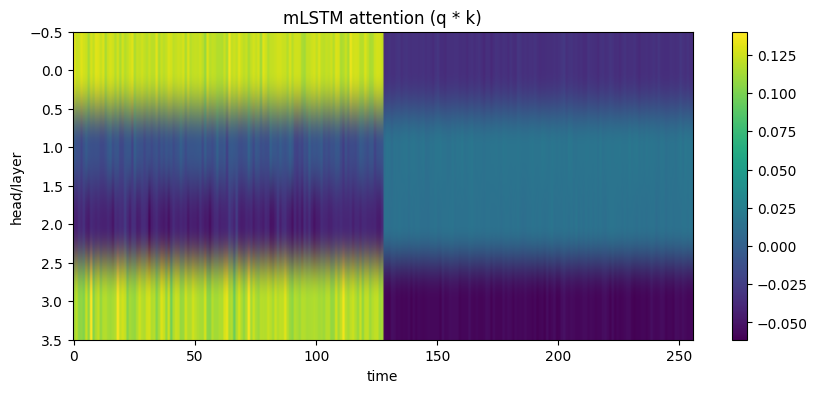

In [36]:
plt.figure(figsize=(10, 4))
plt.imshow(attn.T.cpu(), aspect="auto")
plt.colorbar()
plt.xlabel("time")
plt.ylabel("head/layer")
plt.title("mLSTM attention (q * k)")
plt.show()


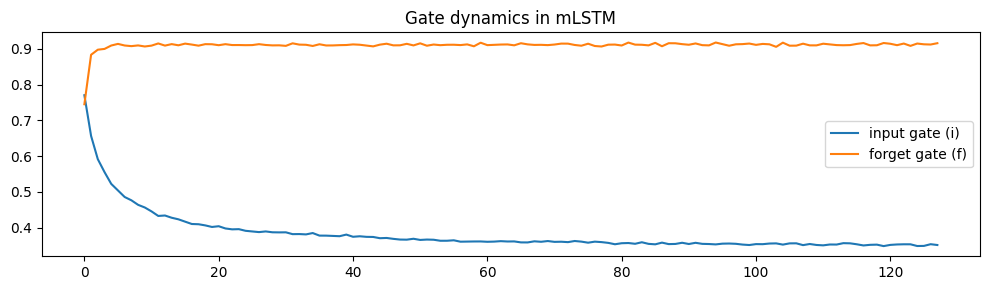

In [37]:
i_logs = torch.stack(model.layers[0].i_logs).mean(dim=1).mean(-1)
f_logs = torch.stack(model.layers[0].f_logs).mean(dim=1).mean(-1)

plt.figure(figsize=(10, 3))
plt.plot(i_logs.cpu(), label="input gate (i)")
plt.plot(f_logs.cpu(), label="forget gate (f)")
plt.legend()
plt.title("Gate dynamics in mLSTM")
plt.tight_layout()
plt.show()


# Вывод
mLSTM эффективно распределяет внимание по последовательности: сначала строится общий контекст, затем фокус смещается на ключевые моменты. Разные головы модели специализируются на разных аспектах данных, что позволяет учитывать как локальные, так и глобальные зависимости при принятии решений. Модель динамически адаптирует своё восприятие данных, выделяя важные элементы для точного прогноза.